### Libraries

In [90]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import topojson as tp
import rasterio
import rasterio.plot
import rasterio.warp
import rasterio.mask

%matplotlib inline

### Data Files

In [4]:
seine = gpd.read_file('data/seine.gpkg')
us_states = gpd.read_file('data/us_states.gpkg')
nz = gpd.read_file('data/nz.gpkg')
src = rasterio.open('data/dem.tif')
src_elev = rasterio.open('output/elev.tif')

## Geometry Operations
* Unary - Operations on one object
* Binary - Changing the characteristics of one object based on the characteristics of another
* Type - Changing the type of object, e.g. a polygon into a line

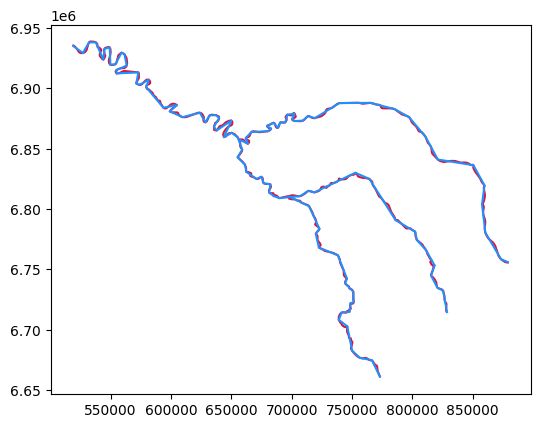

In [7]:
# simplify reduces the resolution / memory of a geometry
# within a tolerance of 2000m
seine_simp = seine.simplify(2000)

fig, ax = plt.subplots()
seine.plot(ax = ax, color = 'crimson');
seine_simp.plot(ax = ax, color = 'dodgerblue');

In [16]:
us_states9311 = us_states[us_states9311.NAME.isin(['Michigan', 'Wisconsin', 'Ohio'])].to_crs(9311)

# geopandas simplify method does not preserve boundaries
us_states_simp1 = us_states9311[us_states9311.NAME.isin(['Michigan', 'Wisconsin', 'Ohio'])].simplify(100000)

# simplify keeping boundaries together
us_states_simp2 = tp.Topology(us_states9311[us_states9311.NAME.isin(['Michigan', 'Wisconsin', 'Ohio'])], prequantize=False).toposimplify(100000).to_gdf()

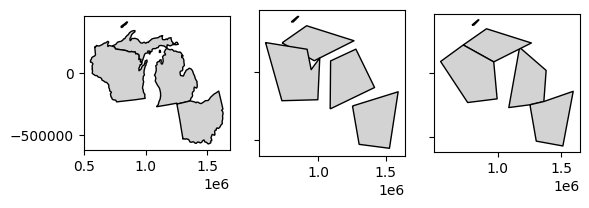

In [18]:
fig, ax = plt.subplots(1, 3, sharey = True)
us_states9311.plot(color='lightgrey', edgecolor='black', ax = ax[0]);
us_states_simp1.plot(color='lightgrey', edgecolor='black', ax = ax[1]);
us_states_simp2.plot(color='lightgrey', edgecolor='black', ax = ax[2]);

### Centroids and Buffers

Both methods return a GeoSeries object, even if the input is a GeoDataFrame

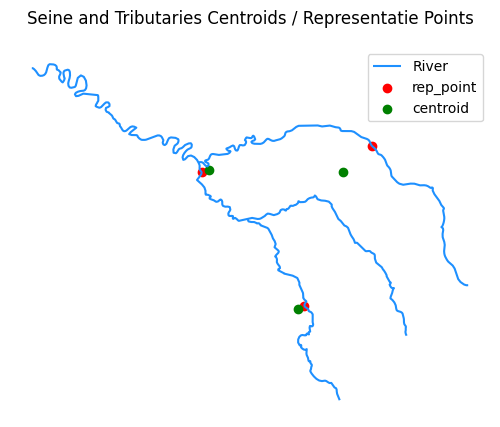

In [28]:
seine_centroid = seine.centroid
seine_pos = seine.representative_point()
base = seine.plot(color='dodgerblue')
seine_pos.plot(ax=base, color='red', edgecolor='red')
seine_centroid.plot(ax=base, color='green', edgecolor='green')
plt.legend(['River','rep_point', 'centroid'])
plt.title('Seine and Tributaries Centroids / Representatie Points')
base.set_axis_off()
plt.show()

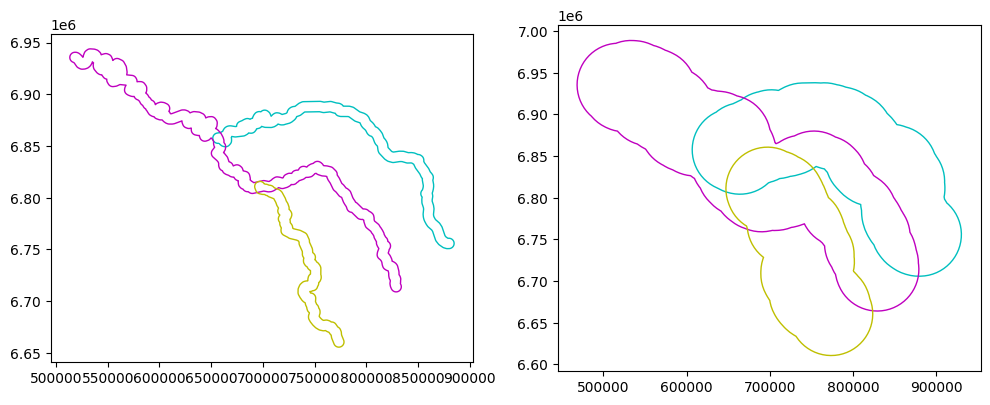

In [33]:
seine_buff_5km = seine.buffer(5000)
seine_buff_50km = seine.buffer(50000)

fig, ax = plt.subplots(1,2, figsize = (12, 6))
seine_buff_5km.plot(color='none', edgecolor=['c', 'm', 'y'], ax = ax[0]);
seine_buff_50km.plot(color='none', edgecolor=['c', 'm', 'y'], ax = ax[1]);

### Affine Transformations


* .translate(xoff=0.0, yoff=0.0) shifts coordinates
* .scale(xfact=1.0, yfact=1.0, origin='center') scales vectors by a factor
* .rotate(angle, origin='center', use_radians=False) rotates vecotrs around a central point


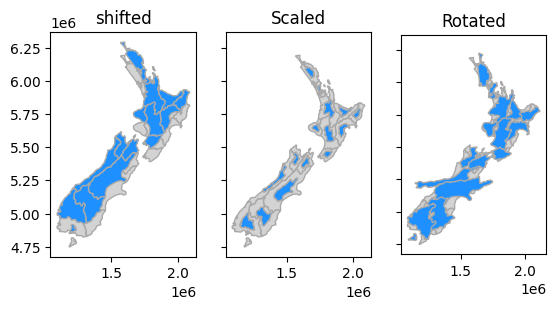

In [38]:
nz_rotate = nz.rotate(-30, origin='centroid')
nz_scale = nz.scale(0.5, 0.5, origin='centroid')
nz_shift = nz.translate(0, 100000)

fig, ax = plt.subplots(1, 3, sharey = True)

# Shift
nz.plot(color='lightgrey', edgecolor='darkgrey', ax = ax[0])
nz_shift.plot(ax=ax[0], color='dodgerblue', edgecolor='darkgrey')
# Scale
nz.plot(color='lightgrey', edgecolor='darkgrey', ax = ax[1])
nz_scale.plot(ax=ax[1], color='dodgerblue', edgecolor='darkgrey')
# Rotate
nz.plot(color='lightgrey', edgecolor='darkgrey', ax = ax[2])
nz_rotate.plot(ax=ax[2], color='dodgerblue', edgecolor='darkgrey')
ax[0].set_title('shifted')
ax[1].set_title('Scaled')
ax[2].set_title('Rotated')
plt.show()

### Pairwise Geometry-Generating Functions
* intersection - returns a polygon of the overlapping area
* difference - returns a polygon of the area not overlapping
* union - combines the two geometries into one
* symetric_difference - union, but without the overlapping area

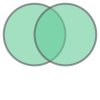

In [39]:
x = shapely.Point((0, 0)).buffer(1)
y = shapely.Point((1, 0)).buffer(1)
shapely.GeometryCollection([x, y])

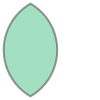

In [40]:
x.intersection(y)

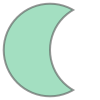

In [41]:
x.difference(y)

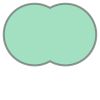

In [42]:
x.union(y)

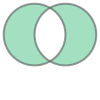

In [43]:
x.symmetric_difference(y)

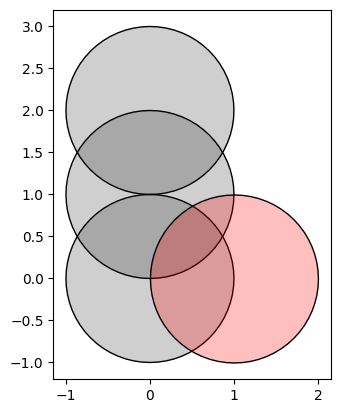

In [48]:
geom1 = gpd.GeoSeries(x)
geom2 = geom1.translate(0, 1)
geom3 = geom1.translate(0, 2)
geom = pd.concat([geom1, geom2, geom3])

fig, ax = plt.subplots()
geom.plot(color='#00000030', edgecolor='black', ax=ax)
gpd.GeoSeries(y).plot(color='#FF000040', edgecolor='black', ax=ax)
plt.show()

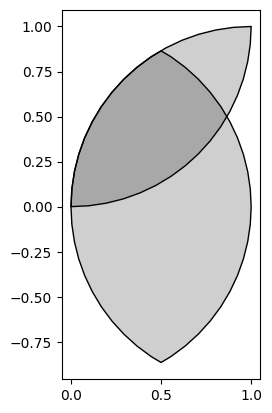

In [49]:
geom_inter_y = geom.intersection(y)
geom_inter_y.plot(color='#00000030', edgecolor='black')
plt.show()

### Dissolve

Joins touching geometries and aggregates their vector attributes. Use union_all per group.

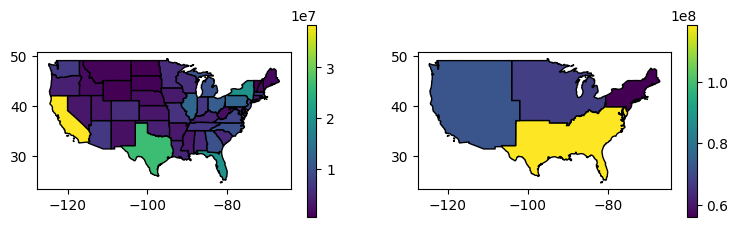

In [54]:
regions = us_states[['REGION', 'geometry', 'total_pop_15']].dissolve(by='REGION', aggfunc='sum').reset_index()

fig, ax = plt.subplots(1, 2, figsize=(9, 2.5))
us_states.plot(ax=ax[0], edgecolor='black', column='total_pop_15', legend=True);
regions.plot(ax=ax[1], edgecolor='black', column='total_pop_15', legend=True);

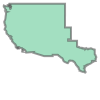

In [58]:
# select and union_all to create a single geometry of Western US and Texas
texas_union = us_states[(us_states['REGION'] == 'West') | (us_states['NAME'] == 'Texas')]
texas_union = texas_union.union_all()
texas_union

<Axes: >

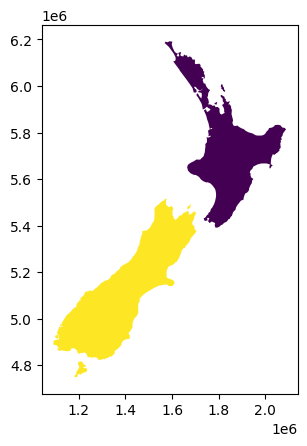

In [70]:
# Dissolve Two Islands of New Zealand. Does not preserve internal borders
nz_dis1 = nz[['Island', 'Population', 'geometry']] \
    .dissolve(by='Island', aggfunc='sum') \
    .reset_index()

nz_dis1.plot(cmap = 'viridis')

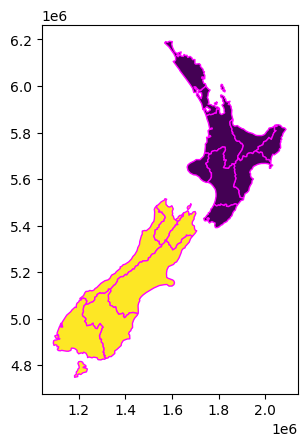

In [76]:
# If wanting to preserve internal borders use pandas functions to aggregate
nz_dis2 = (nz 
    .groupby('Island')
    .agg({
        'Population': 'sum',
        'geometry': lambda x: shapely.MultiPolygon(x.explode().to_list())
    })).reset_index()

# convert back to GeoDataFrame
nz_dis2 = gpd.GeoDataFrame(nz_dis2).set_geometry('geometry').set_crs(nz.crs)
nz_dis2.plot(cmap = 'viridis', edgecolor = 'magenta')
plt.show()

## Raster Operations

In [78]:
# padding using Numpy
r = src_elev.read(1)
rows = 1
cols = 2
r_pad = np.pad(r, ((rows,rows),(cols,cols)), constant_values=18)
r_pad

array([[18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
       [18, 18,  1,  2,  3,  4,  5,  6, 18, 18],
       [18, 18,  7,  8,  9, 10, 11, 12, 18, 18],
       [18, 18, 13, 14, 15, 16, 17, 18, 18, 18],
       [18, 18, 19, 20, 21, 22, 23, 24, 18, 18],
       [18, 18, 25, 26, 27, 28, 29, 30, 18, 18],
       [18, 18, 31, 32, 33, 34, 35, 36, 18, 18],
       [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]], dtype=uint8)

In [79]:
# dx (scale x), shear_factor_x (rotation), xmin (x origin), 
# shear_factor_y (rotation), dy (scale y), ymax (y origin)
src_elev.transform 

Affine(0.5, 0.0, -1.5,
       0.0, -0.5, 1.5)

In [83]:
# origin
xmin, ymax = src_elev.transform[2], src_elev.transform[5]
print(xmin, ymax)

# resolution
dx, dy = src_elev.transform[0], src_elev.transform[4]
print(dx, dy)

# new origin after padding
xmin_new = xmin - dx * cols
ymax_new = ymax - dy * rows
print(xmin_new, ymax_new)

-1.5 1.5
0.5 -0.5
-2.5 2.0


In [84]:
new_transform = rasterio.transform.from_origin(
    west=xmin_new, 
    north=ymax_new, 
    xsize=dx, 
    ysize=abs(dy)
)
new_transform

Affine(0.5, 0.0, -2.5,
       0.0, -0.5, 2.0)

### Aggregation and Disaggregation

These methods alter the resolution of rasters, e.g. to match the resolution of other layers. 

Aggregation effectively downsamples a raster to a lower resolution. 

Disaggregation upsamples rasters throught either nearest neighbor resampling to preserve values, or something like bilinear resampling to smooth out continuous values. 

In [87]:
print(src.read(1).shape)
print(src.transform)

factor = 0.2
r = src.read(1,
    out_shape=(
        int(src.height * factor),
        int(src.width * factor)
        ),
    resampling=rasterio.enums.Resampling.average
)

# transformed shape
print(r.shape)

# update transform
new_transform = src.transform * src.transform.scale(
    (src.width / r.shape[1]),
    (src.height / r.shape[0])
)

print(new_transform)

(117, 117)
| 30.85, 0.00, 794599.11|
| 0.00,-30.85, 8935384.32|
| 0.00, 0.00, 1.00|
(23, 23)
| 156.93, 0.00, 794599.11|
| 0.00,-156.93, 8935384.32|
| 0.00, 0.00, 1.00|


Text(0.5, 1.0, 'Aggregated')

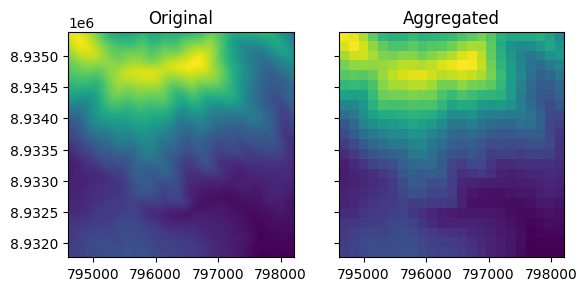

In [98]:
fig, ax = plt.subplots(1, 2, sharey=True)
rasterio.plot.show(src, ax = ax[0]);
rasterio.plot.show(r, transform=new_transform, ax = ax[1])
ax[0].set_title('Original')
ax[1].set_title('Aggregated')

In [92]:
# write the updated raster
dst_kwargs = src.meta.copy()

dst_kwargs.update({
    'transform': new_transform,
    'width': r.shape[1],
    'height': r.shape[0]})

dst = rasterio.open('output/dem_agg5.tif', 'w', **dst_kwargs)
dst.write(r, 1)
dst.close()

In [94]:
# Disaggregation with bilinear transform
factor = 5
r2 = src.read(1,
    out_shape=(
        int(src.height * factor),
        int(src.width * factor)
        ),
    resampling=rasterio.enums.Resampling.bilinear
)

new_transform2 = src.transform * src.transform.scale(
    (src.width / r2.shape[1]),
    (src.height / r2.shape[0])
)

new_transform2

Affine(6.169999999999921, 0.0, 794599.1076146346,
       0.0, -6.169999999998726, 8935384.324602526)

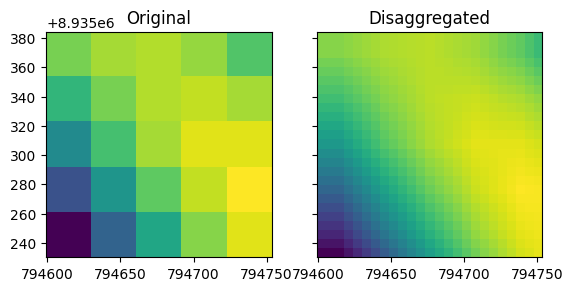

In [97]:

fig, ax = plt.subplots(1, 2, sharey=True)
rasterio.plot.show(src.read(1)[:5, :5], transform=src.transform, ax = ax[0])
rasterio.plot.show(r2[:25, :25], transform=new_transform2, ax = ax[1])
ax[0].set_title('Original')
ax[1].set_title('Disaggregated')
plt.show()

### Resampling

Used when you need to match rasters with different with different origins and resolutions. 

Use nearest-neighbor resampling for categorical raster values.

Continuous values can use several different techniques.

Reprojection and resampling are essentially the same thing, but depends on the origin and crs of the two target rasters.

In [99]:
xmin = 794650
xmax = 798250
ymin = 8931750 
ymax = 8935350
res = 300

# resample a 30m resolution raster to match a 300m resolution raster
dst_transform = rasterio.transform.from_origin(
    west=794650, 
    north=8935350, 
    xsize=300, 
    ysize=300)

width = int((xmax - xmin) / res)
height = int((ymax - ymin) / res)
print(width, height)

dst_kwargs = src.meta.copy()
dst_kwargs.update({
    'transform': dst_transform,
    'width': width,
    'height': height})

# nearest neighbors resampling
dst = rasterio.open('output/dem_resample_nearest.tif', 'w', **dst_kwargs)
rasterio.warp.reproject(
    source=rasterio.band(src, 1),
    destination=rasterio.band(dst, 1),
    src_transform=src.transform,
    src_crs=src.crs,
    dst_transform=dst_transform,
    dst_crs=src.crs,
    resampling=rasterio.enums.Resampling.nearest)
dst.close()

# maximum value resampling
dst = rasterio.open('output/dem_resample_maximum.tif', 'w', **dst_kwargs)
rasterio.warp.reproject(
    source=rasterio.band(src, 1),
    destination=rasterio.band(dst, 1),
    src_transform=src.transform,
    src_crs=src.crs,
    dst_transform=dst_transform,
    dst_crs=src.crs,
    resampling=rasterio.enums.Resampling.max
)

dst.close()

12 12


Text(0.5, 1.0, 'Max')

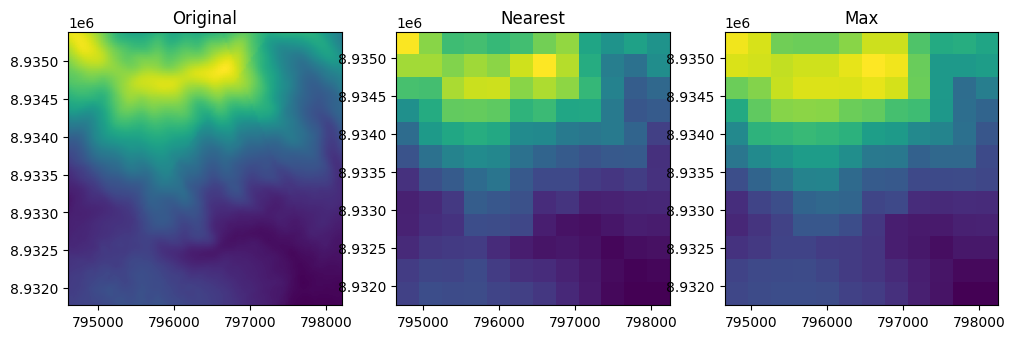

In [101]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
rasterio.plot.show(src, ax=ax[0])
rasterio.plot.show(rasterio.open('output/dem_resample_nearest.tif'), ax=ax[1])
rasterio.plot.show(rasterio.open('output/dem_resample_maximum.tif'), ax=ax[2])
ax[0].set_title('Original')
ax[1].set_title('Nearest')
ax[2].set_title('Max')